## VAE Toturial for Cifar10 Dataset

Ref to <https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb>

In [1]:
import os
import matplotlib.pylab as plt
import torch 
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import math
import numpy as np

from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Grayscale()
    ]
)
    
def load_data(batch_size=128, n_workers=4):
    
    original_training_ds = CIFAR10(root='data/', download=True, transform=transform)
    test_ds = CIFAR10(root='data/', train=False, transform=transform)
    
    torch.manual_seed(12345)
    n_train = int(len(original_training_ds)*0.9)
    n_val = len(original_training_ds) - n_train
    print("n_train: %s, n_val: %s, n_test: %s" % (n_train, n_val, len(test_ds)))
    
    training_ds, val_ds = random_split(original_training_ds, [n_train, n_val])
    
    training_dl = DataLoader(training_ds, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_workers, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    
    return training_dl, val_dl, test_dl



In [3]:
training_dl, val_dl, test_dl = load_data()

Files already downloaded and verified
n_train: 45000, n_val: 5000, n_test: 10000


images.shape: torch.Size([128, 1, 32, 32])
x, x.shape:  torch.Size([128, 1024])
gray images.shape: torch.Size([128, 1, 32, 32])
max, min: tensor(0.9999) tensor(0.) torch.float32


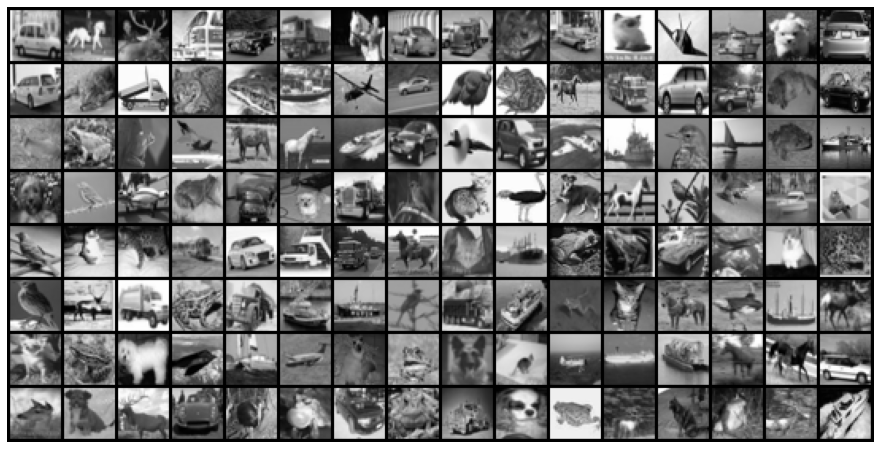

In [4]:
for images, _ in training_dl:
    print('images.shape:', images.shape)
    x = torch.reshape(images, [images.shape[0], -1])
    print("x, x.shape: ", x.shape)
    images = torchvision.transforms.functional.rgb_to_grayscale(images)
    print('gray images.shape:', images.shape)
    print('max, min:', torch.max(images), torch.min(images), images.dtype)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

786432


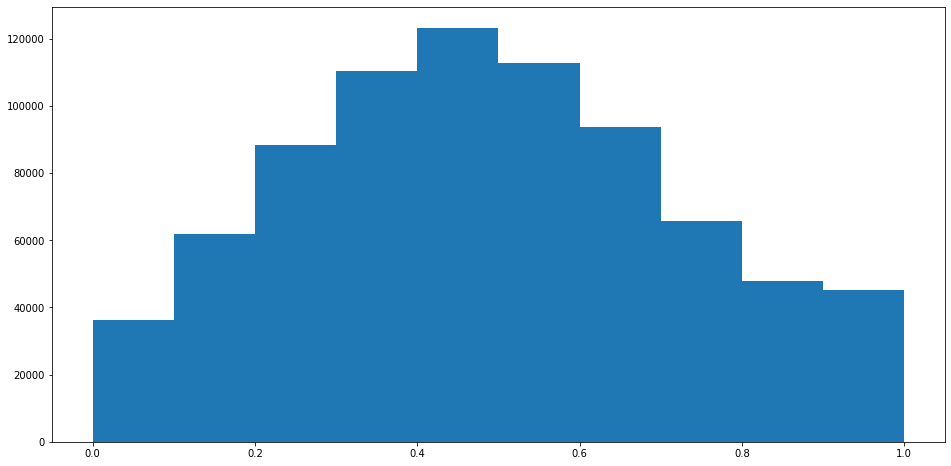

In [5]:
# Plot histogram of pixel value of datasets.
# Use 10 batches
pixels = []
for i, (images, _) in enumerate(training_dl):
    images = torchvision.transforms.functional.rgb_to_grayscale(images)
    if i > 5:
        break
    pixels.append(images.flatten().cpu().numpy())
pixels = np.concatenate(pixels)
print(len(pixels))
plt.figure(figsize=(16,8))
_ = plt.hist(pixels, bins=10, range=(0.0, 1.0))

plt.show()

In [6]:
def get_device():
    env_device = os.environ.get('TORCH_DEVICE', "")
    print("TORCH_DEVICE: '%s'" % env_device)
    if env_device == "cpu":
        device = torch.device("cpu")
    elif env_device == "mps":
        device = torch.device("mps")
    else:
        device = torch.device("cuda" if torch.cuda.is_available()
                          else "mps" if torch.backends.mps.is_built() else "cpu")  # Select device for inference
    print("device: %s" % device)

    return device

X_DIM = 32*32

class VAENet(torch.nn.Module):
    
    def __init__(self, x_dim, encoder_dims, decoder_dims, z_dim):
        super(VAENet, self).__init__()
        
        # encoder part:
        self.encoder_block = torch.nn.Sequential()
        prev_dim = x_dim
        for dim in encoder_dims:
            self.encoder_block.append(torch.nn.Linear(prev_dim, dim))
            self.encoder_block.append(torch.nn.ReLU())
            prev_dim = dim
            
        self.encoder_last_fc1, self.encoder_last_fc2  = \
            torch.nn.Linear(prev_dim, z_dim), torch.nn.Linear(prev_dim, z_dim)
    
        self.decoder_block = torch.nn.Sequential()
        prev_dim = z_dim
        for dim in decoder_dims:
            self.decoder_block.append(torch.nn.Linear(prev_dim, dim))
            self.decoder_block.append(torch.nn.ReLU())
            prev_dim = dim
        
        self.decoder_last_fc = torch.nn.Linear(prev_dim, x_dim)
    
    def encode(self, x):
        h = self.encoder_block(x)
    
        mu = self.encoder_last_fc1(h)
        log_var = self.encoder_last_fc2(h)
        
        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(mu)
        
        return mu + std*eps
    
    def decode(self, z):
        h = self.decoder_block(z)
        
        return torch.sigmoid(self.decoder_last_fc(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        # rc_x: reconstructed x
        rc_x = self.decode(z)
        #print("mu, log_var, z, rc_x: ", mu.shape, log_var.shape, z.shape, rc_x.shape)
        
        return rc_x, mu, log_var

DEBUG_slot = dict()
def vae_loss_fn(x, rc_x, mu, log_var):
    # log(p(x|z))
    # bce_loss = F.binary_cross_entropy(rc_x, x, reduction="sum")
    # Use mse as reconstructed loss
    rc_loss = F.mse_loss(rc_x, x, reduction="sum")
    DEBUG_slot['x'] = x.cpu()
    DEBUG_slot['rc_x'] = rc_x.cpu()    
    DEBUG_slot['rc_loss'] = rc_loss.cpu()
    
    kld_loss = -0.5*torch.sum(1 + log_var - torch.exp(log_var) - mu*mu)
    DEBUG_slot['mu'] = mu
    DEBUG_slot['log_var'] = log_var
    DEBUG_slot['kld_loss'] = kld_loss
    
    loss = kld_loss + rc_loss
    
    return loss
      

In [7]:
device = get_device()
print("device used: %s" % device)
vae = VAENet(x_dim=X_DIM, encoder_dims=[512, 256], decoder_dims=[256, 512], z_dim=2).to(device)
print(vae)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)
print(optimizer)

TORCH_DEVICE: ''
device: mps
device used: mps
VAENet(
  (encoder_block): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (encoder_last_fc1): Linear(in_features=256, out_features=2, bias=True)
  (encoder_last_fc2): Linear(in_features=256, out_features=2, bias=True)
  (decoder_block): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (decoder_last_fc): Linear(in_features=512, out_features=1024, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [8]:
def train(epoch):
    vae.train()
    loss_sum = 0.0
    
    for batch_idx, (x, _) in enumerate(training_dl):
        x = x.to(device)
        x = torch.reshape(x, [-1, X_DIM])
        optimizer.zero_grad()
        
        rc_x, mu, log_var = vae(x)
        loss = vae_loss_fn(x, rc_x, mu, log_var)
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(training_dl.dataset),
                100. * batch_idx / len(training_dl), loss.item() / len(x)))
            
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss_sum / len(training_dl.dataset)))

def test():
    vae.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, _ in test_dl:
            x = x.to(device)
            x = torch.reshape(x, [-1, X_DIM])
            rc_x, mu, log_var = vae(x)
            loss_sum += vae_loss_fn(x, rc_x, mu, log_var)
    
    print('====> Test set loss: {:.4f}'.format(loss_sum/len(test_dl.dataset)))

def val():
    vae.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, _ in val_dl:
            x = x.to(device)
            x = torch.reshape(x, [-1, X_DIM])
            rc_x, mu, log_var = vae(x)
            loss_sum += vae_loss_fn(x, rc_x, mu, log_var)
    
    print('====> Validation set loss: {:.4f}'.format(loss_sum/len(val_dl.dataset)))

In [9]:
for epoch in range(1, 50):
    train(epoch)
    val()
test()

Train Epoch: 1 [0/45000 (0%)]	Loss: 59.493813
Train Epoch: 1 [12800/45000 (28%)]	Loss: 41.110039
Train Epoch: 1 [25600/45000 (57%)]	Loss: 44.757652
Train Epoch: 1 [38400/45000 (85%)]	Loss: 39.715805
====> Epoch: 1 Average loss: 46.3616
====> Validation set loss: 40.6858
Train Epoch: 2 [0/45000 (0%)]	Loss: 38.779636
Train Epoch: 2 [12800/45000 (28%)]	Loss: 36.412216
Train Epoch: 2 [25600/45000 (57%)]	Loss: 38.167061
Train Epoch: 2 [38400/45000 (85%)]	Loss: 38.856476
====> Epoch: 2 Average loss: 37.8660
====> Validation set loss: 37.8016
Train Epoch: 3 [0/45000 (0%)]	Loss: 37.961246
Train Epoch: 3 [12800/45000 (28%)]	Loss: 38.056248
Train Epoch: 3 [25600/45000 (57%)]	Loss: 36.978592
Train Epoch: 3 [38400/45000 (85%)]	Loss: 37.358871
====> Epoch: 3 Average loss: 37.3360
====> Validation set loss: 37.6365
Train Epoch: 4 [0/45000 (0%)]	Loss: 37.654339
Train Epoch: 4 [12800/45000 (28%)]	Loss: 40.122395
Train Epoch: 4 [25600/45000 (57%)]	Loss: 33.746586
Train Epoch: 4 [38400/45000 (85%)]	Loss

====> Validation set loss: 36.9715
Train Epoch: 31 [0/45000 (0%)]	Loss: 37.602062
Train Epoch: 31 [12800/45000 (28%)]	Loss: 35.710754
Train Epoch: 31 [25600/45000 (57%)]	Loss: 38.261452
Train Epoch: 31 [38400/45000 (85%)]	Loss: 36.676907
====> Epoch: 31 Average loss: 36.8284
====> Validation set loss: 37.4895
Train Epoch: 32 [0/45000 (0%)]	Loss: 37.132481
Train Epoch: 32 [12800/45000 (28%)]	Loss: 35.292324
Train Epoch: 32 [25600/45000 (57%)]	Loss: 37.771980
Train Epoch: 32 [38400/45000 (85%)]	Loss: 38.716122
====> Epoch: 32 Average loss: 36.7949
====> Validation set loss: 37.3658
Train Epoch: 33 [0/45000 (0%)]	Loss: 37.191719
Train Epoch: 33 [12800/45000 (28%)]	Loss: 37.361279
Train Epoch: 33 [25600/45000 (57%)]	Loss: 36.957962
Train Epoch: 33 [38400/45000 (85%)]	Loss: 35.520428
====> Epoch: 33 Average loss: 36.8025
====> Validation set loss: 36.9206
Train Epoch: 34 [0/45000 (0%)]	Loss: 39.739716
Train Epoch: 34 [12800/45000 (28%)]	Loss: 39.110325
Train Epoch: 34 [25600/45000 (57%)]	Lo

tensor(0.9374) tensor(0.0335)
torch.Size([64, 1, 32, 32])


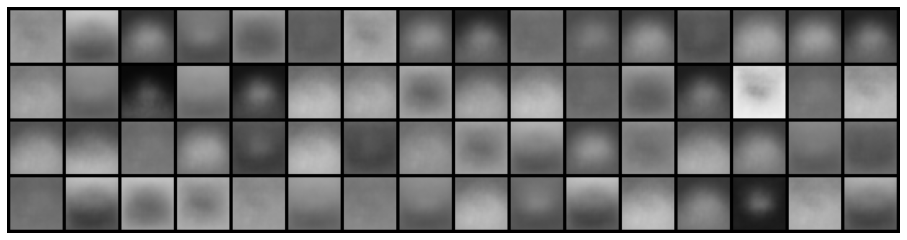

In [12]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    image_samples = vae.decode(z).cpu()
    print(torch.max(image_samples), torch.min(image_samples))
    image_samples = image_samples.reshape(64, 1, 32, 32)
    print(image_samples.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image_samples, nrow=16).permute(1, 2, 0))    